In [1]:
import collections
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow_text as tf_text

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [3]:
dataset_dir = '..\\data'
train_dir = f"{dataset_dir}\\tr"
batch_size = 32
seed = 42
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [4]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [5]:
"""FILE_NAMES = ['negativesentences.txt', 'neutralsentences.txt', 'positivesentences.txt']
FILE_NAMES2 = ['negative_valence_sentences.txt', 'neg.txt', 'neg_test.txt']
FILE_NAMES3 = ['pos.txt', 'pos_test.txt']"""
FILE_NAMES = ['combinedneg.txt', 'combinedneut.txt', 'combinedpos.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)
"""for file_name in FILE_NAMES2:
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))
    labeled_data_sets.append(labeled_dataset)
for file_name in FILE_NAMES3:
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 2))
    labeled_data_sets.append(labeled_dataset)
"""

'for file_name in FILE_NAMES2:\n    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")\n    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))\n    labeled_data_sets.append(labeled_dataset)\nfor file_name in FILE_NAMES3:\n    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")\n    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 2))\n    labeled_data_sets.append(labeled_dataset)\n'

In [6]:
"""labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp0.txt")
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))
labeled_data_sets.append(labeled_dataset)
lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp1.txt")
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 1))
labeled_data_sets.append(labeled_dataset)
lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp2.txt")
labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 2))
labeled_data_sets.append(labeled_dataset)"""

'labeled_data_sets = []\n# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.\nlines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp0.txt")\nlabeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 0))\nlabeled_data_sets.append(labeled_dataset)\nlines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp1.txt")\nlabeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 1))\nlabeled_data_sets.append(labeled_dataset)\nlines_dataset = tf.data.TextLineDataset(f"{train_dir}\\tmp2.txt")\nlabeled_dataset = lines_dataset.map(lambda ex: labeler(ex, 2))\nlabeled_data_sets.append(labeled_dataset)'

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32
VALIDATION_SIZE = 300
VOCAB_SIZE = 35000

In [8]:
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [9]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'alkuper\xc3\xa4iselle kirjoittajalle: \xc3\xa4l\xc3\xa4 sure.'
Label: 1
Sentence:  b'se on meid\xc3\xa4n lempilaulumme.'
Label: 2
Sentence:  b'kyll\xc3\xa4 aamiaislehdest\xc3\xa4 eroon p\xc3\xa4\xc3\xa4see.'
Label: 1
Sentence:  b'mies ei halua loukata ket\xc3\xa4\xc3\xa4n.'
Label: 2
Sentence:  b'h\xc3\xa4nen piti olla sinun kanssasi.'
Label: 0
Sentence:  b'ei kannata uskoa kaikkea paskaa mit\xc3\xa4 jutuupista l\xc3\xb6yt\xc3\xa4\xc3\xa4.'
Label: 0
Sentence:  b'mary pat, mary kate, mary frances, vauhtia!'
Label: 0
Sentence:  b'koko el\xc3\xa4m\xc3\xa4ni on ollut kilpailua sek\xc3\xa4 kilparadalla ett\xc3\xa4 t\xc3\xb6iss\xc3\xa4.'
Label: 0
Sentence:  b'foo-fookin sanoo heippa!'
Label: 2
Sentence:  b'oletko luuseri vai kova luu? :d'
Label: 2


In [10]:
tokenizer = tf_text.UnicodeScriptTokenizer()

In [11]:
def tokenize(text, unused_label):
    lower_case = tf_text.case_fold_utf8(text)
    return tokenizer.tokenize(lower_case)

tokenized_ds = all_labeled_data.map(tokenize)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [12]:
for text_batch in tokenized_ds.take(5):
    print("Tokens: ", text_batch.numpy())

Tokens:  [b'alkuper\xc3\xa4iselle' b'kirjoittajalle' b':' b'\xc3\xa4l\xc3\xa4'
 b'sure' b'.']
Tokens:  [b'se' b'on' b'meid\xc3\xa4n' b'lempilaulumme' b'.']
Tokens:  [b'kyll\xc3\xa4' b'aamiaislehdest\xc3\xa4' b'eroon'
 b'p\xc3\xa4\xc3\xa4see' b'.']
Tokens:  [b'mies' b'ei' b'halua' b'loukata' b'ket\xc3\xa4\xc3\xa4n' b'.']
Tokens:  [b'h\xc3\xa4nen' b'piti' b'olla' b'sinun' b'kanssasi' b'.']


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
    return dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
tokenized_ds = configure_dataset(tokenized_ds)

vocab_dict = collections.defaultdict(lambda: 0)
for toks in tokenized_ds.as_numpy_iterator():
    for tok in toks:
        vocab_dict[tok] += 1

vocab = sorted(vocab_dict.items(), key=lambda x: x[1], reverse=True)
vocab = [token for token, count in vocab]
vocab = vocab[:VOCAB_SIZE]
vocab_size = len(vocab)
print("Vocab size: ", vocab_size)
n = 50
print(f"First {n} vocab entries:", vocab[:50])

Vocab size:  35000
First 50 vocab entries: [b'.', b',', b'on', b'ja', b'?', b'ei', b'!', b'se', b'ett\xc3\xa4', b'en', b'ole', b'h\xc3\xa4n', b'-', b'mutta', b'kun', b'jos', b'niin', b'olen', b'mit\xc3\xa4', b'"', b'oli', b'voi', b'nyt', b'kuin', b'vain', b'min\xc3\xa4', b'sen', b't\xc3\xa4m\xc3\xa4', b'olla', b'olet', b'ovat', b'kaikki', b'sit\xc3\xa4', b'sin\xc3\xa4', b':', b'..', b'kyll\xc3\xa4', b'et', b'sitten', b'hyv\xc3\xa4', b'minua', b'mit\xc3\xa4\xc3\xa4n', b'siit\xc3\xa4', b'jo', b'tai', b'hyvin', b'miksi', b'onko', b'minun', b'olisi']


In [15]:
keys = vocab
values = range(2, len(vocab) + 2)  # reserve 0 for padding, 1 for OOV

init = tf.lookup.KeyValueTensorInitializer(
    keys, values, key_dtype=tf.string, value_dtype=tf.int64)

num_oov_buckets = 1
vocab_table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)

In [16]:
def preprocess_text(text, label):
    standardized = tf_text.case_fold_utf8(text)
    tokenized = tokenizer.tokenize(standardized)
    vectorized = vocab_table.lookup(tokenized)
    return vectorized, label

In [17]:
example_text, example_label = next(iter(all_labeled_data))
print("Sentence: ", example_text.numpy())
vectorized_text, example_label = preprocess_text(example_text, example_label)
print("Vectorized sentence: ", vectorized_text.numpy())

Sentence:  b'alkuper\xc3\xa4iselle kirjoittajalle: \xc3\xa4l\xc3\xa4 sure.'
Vectorized sentence:  [14312 14313    36    63 14314     2]


In [18]:
all_encoded_data = all_labeled_data.map(preprocess_text)

train_data = all_encoded_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE)
validation_data = all_encoded_data.take(VALIDATION_SIZE)

train_data = train_data.padded_batch(BATCH_SIZE)
validation_data = validation_data.padded_batch(BATCH_SIZE)

In [19]:
sample_text, sample_labels = next(iter(validation_data))
print("Text batch shape: ", sample_text.shape)
print("Label batch shape: ", sample_labels.shape)
print("First text example: ", sample_text[0])
print("First label example: ", sample_labels[0])

Text batch shape:  (32, 12)
Label batch shape:  (32,)
First text example:  tf.Tensor([14312 14313    36    63 14314     2     0     0     0     0     0     0], shape=(12,), dtype=int64)
First label example:  tf.Tensor(1, shape=(), dtype=int64)


In [20]:
vocab_size += 2

In [21]:
train_data = configure_dataset(train_data)
validation_data = configure_dataset(validation_data)

In [22]:
def create_model(vocab_size, num_labels):
    model = tf.keras.Sequential([
        layers.Embedding(vocab_size, 64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=True),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.20),
        layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.20),
        layers.Dense(num_labels)
  ])
    return model

In [23]:
model = create_model(vocab_size=vocab_size, num_labels=3)
model.summary()
early_stop = callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
history = model.fit(train_data, validation_data=validation_data, callbacks=[early_stop], epochs=15)
model.save(f'model/rnn_{time}.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          2240128   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [24]:
test_loss, test_acc = model.evaluate(validation_data)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

10/10 [==============================] - 1s 23ms/step - loss: 1.2346 - accuracy: 0.7567
Test Loss: 1.2346423864364624
Test Accuracy: 0.7566666603088379


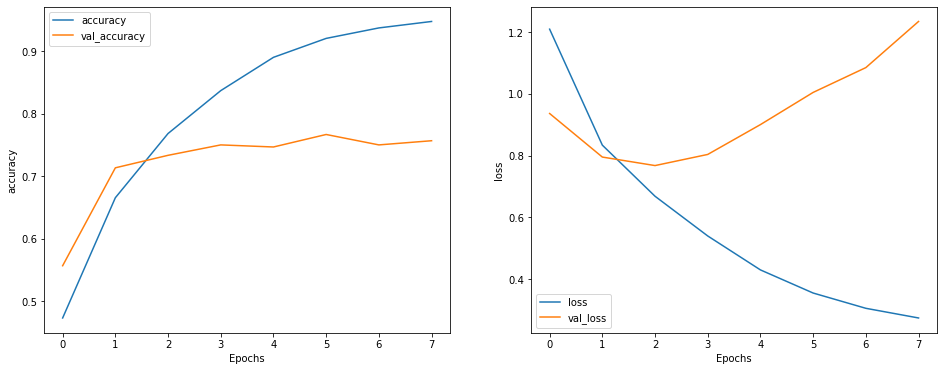

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [26]:
MAX_SEQUENCE_LENGTH = 250
preprocess_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=tf_text.case_fold_utf8,
    split=tokenizer.tokenize,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)
preprocess_layer.set_vocabulary(vocab)

In [27]:
export_model = tf.keras.Sequential(
    [preprocess_layer, model,
     layers.Activation('softmax')])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
# Create a test dataset of raw strings
test_ds = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE)
test_ds = configure_dataset(test_ds)
loss, accuracy = export_model.evaluate(test_ds)
print("Loss: ", loss)
print(f"Accuracy: {accuracy:2.2%}")

In [ ]:
inputs = [
    "haista sinä kuka sitten ootkin iso ja haiseva vittu!",  # Label: 0
    "Minun mielestäni asiattomiin kirjoituksiin ei kannata koskaan vastata mitään. ",  # Label: 1
    "Ihana kuulla et sulla menee hyvin, olen onnellinen sinun puolestasi =) Oikeesti!"  # Label: 2
]
predicted_scores = export_model.predict(inputs)
print(predicted_scores) 
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())

In [ ]:
inputs = [
    "Alkaa vituttamaan nuo saatanan rengasmainokset, jotka pomppii koko ajan silmille.", # Label: 0
    "Joka vitun asiassa ne vaan ajattelee seksiä ja haluaa vaan sitä.", # Label: 0
    "Mitä olit niin itserakas, nyt se sitten on mennyt päähäsi!", # Label: 0
    "Huumekuolemat johtuvat lähes poikkeuksetta ylianostuksista ja nekin kovien huumeiden kyseessäollen.", # Label: 1
    "Presidenttihän ei saa edustaa omaa poliittista vakaumustaan.",  # Label: 1
    "Lopulta voi käydä myös niin, että vaikka olettekin olleet yhdessä ja nauttineet keskenänne paljosta rakkaudesta," \
" te ette ole enää oikeita kumppaneita seuraavaa vaihetta varten." # Label: 1
    "Tänäänkin kaipaan kainaloa, hymyäsi ja ennenkaikkea halaustasi pusuista puhumattakaan.",  # Label: 2
    "Saan rakastella ja rakastaa häntä jälleen, Laitan hyvää ruokaa ja hieron hartioita.", # Label: 2
    "Hyvää syksynjatkoa kaikille lukijoilleni ja kiitos kommenteistanne." # Label: 2    
]
predicted_scores = export_model.predict(inputs)
print(predicted_scores)
predicted_labels = tf.argmax(predicted_scores, axis=1)
for input, label in zip(inputs, predicted_labels):
    print("Question: ", input)
    print("Predicted label: ", label.numpy())